# Project: predicting orders for Glovo

Imagine you just joined Glovo. Glovo follows a slot-based system for the couriers to fullfil the orders that come in. For simplification, you can imagine those slots are non-overlapping hours, so that every every city has 24 slots every day, one for each hour. Glovo needs to know the optimal number of couriers that are needed on every hour slot of every city. Too many couriers, and there will be many idle couriers not earning money. Too few couriers, and orders will have to wait to be processed, leading to higher delivery times.

At the moment, Operations decides manually how many couriers are needed, based on past demand. As the number of cities grows, this becomes unsustainable. They want to automate the process by which they decide how many courier-slots should be opened every hour. For simplification, we can assume that every Sunday at midnight, we need to know how many couriers we need for every hour of the week that is starting. That means that if today is Sunday, May 8th 23:59, they want us to know how many orders will be placed every hour of the week that goes from May 9th 00:00 to May 15th 23:00, both included. Every Sunday, you can use all data from that week to forecast the next one.

This problem has many steps, but we will keep this project to the order forecast for one city: we want to know, for one city and every Sunday, how many orders we're going to receive on every hour of the upcoming week.

## EDA

Load the file data_BCN.csv

Explore the data, visualise it. Look for trends, cycles and seasonalities. Also, can you find any outliers? days or hours that break those patterns?




In [77]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, date
import seaborn as sns
import pandas as pd
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from fbprophet import Prophet
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import numpy as np

In [78]:
df = pd.read_csv('data_BCN.csv')
df['time'] = pd.to_datetime(df['time'])
# Display the first few rows of the dataframe
print(df.head())

                 time  orders city
0 2021-02-01 00:00:00     0.0  BCN
1 2021-02-01 01:00:00     0.0  BCN
2 2021-02-01 02:00:00     0.0  BCN
3 2021-02-01 03:00:00     0.0  BCN
4 2021-02-01 04:00:00     0.0  BCN


In [79]:
# Get descriptive statistics of the 'orders' column
print(df['orders'].describe())

count    8766.000000
mean       73.145175
std       111.038384
min         0.000000
25%         0.000000
50%        30.000000
75%        97.000000
max       939.000000
Name: orders, dtype: float64


Visualize the data using line plots to identify trends, cycles, and seasonalities.

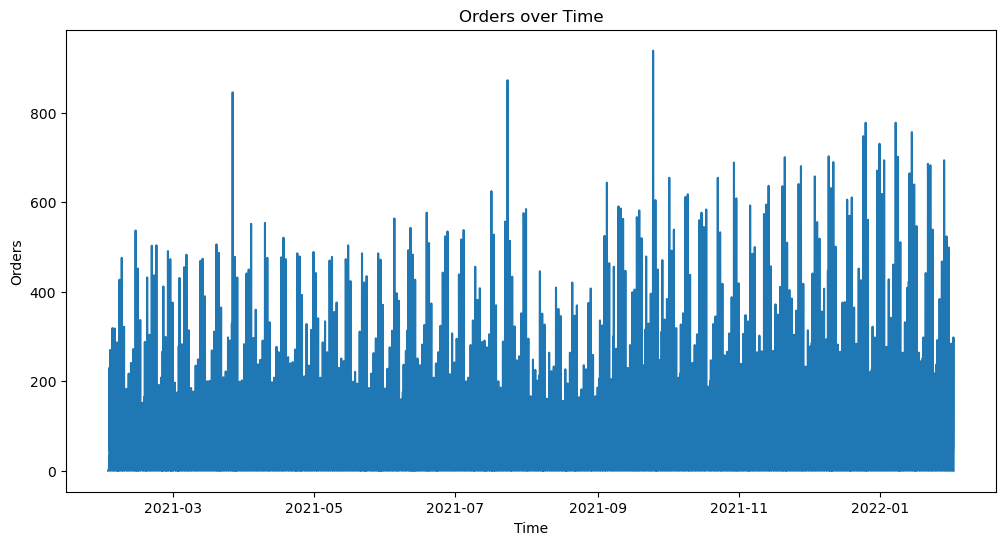

In [80]:
# Line plot of orders over time
plt.figure(figsize=(12, 6))
sns.lineplot(x='time', y='orders', data=df)
plt.title('Orders over Time')
plt.xlabel('Time')
plt.ylabel('Orders')
plt.show()


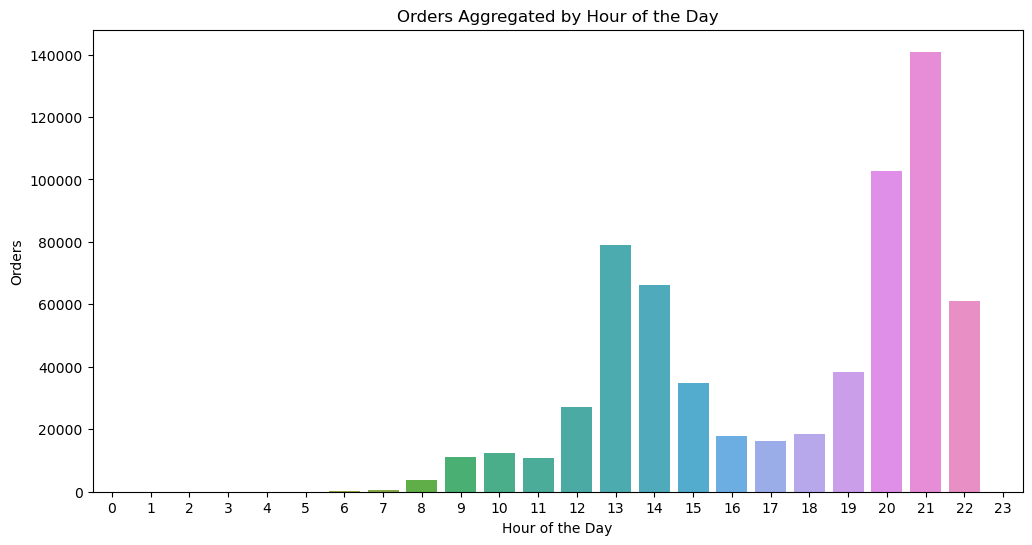

In [81]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Extract the hour component from the 'time' column
df['hour'] = df['time'].dt.hour

# Aggregate the orders by the hour of the day
orders_by_hour = df.groupby('hour')['orders'].sum().reset_index()

# Bar plot of orders aggregated by hour of the day
plt.figure(figsize=(12, 6))
sns.barplot(x='hour', y='orders', data=orders_by_hour)
plt.title('Orders Aggregated by Hour of the Day')
plt.xlabel('Hour of the Day')
plt.ylabel('Orders')
plt.xticks(range(24))
plt.show()


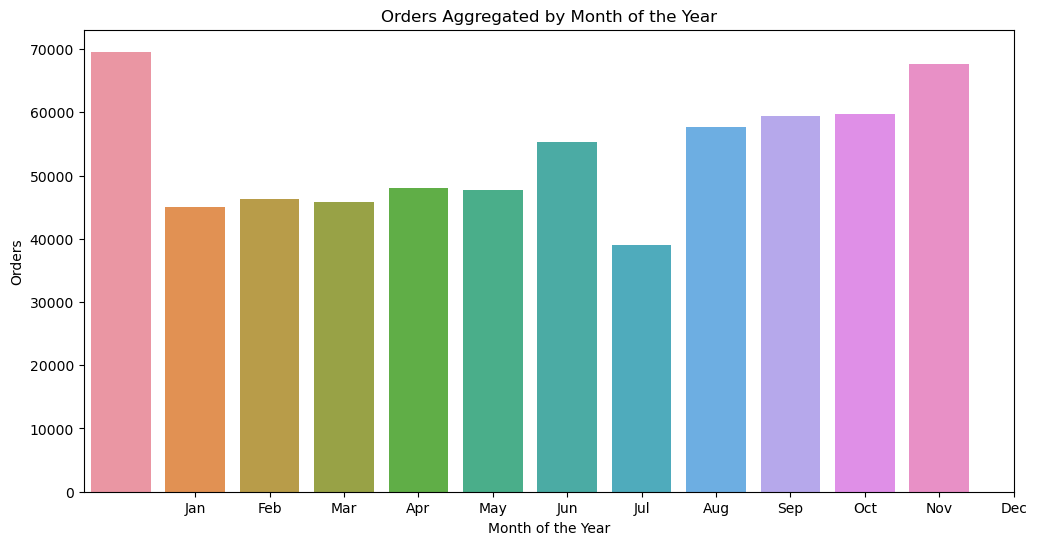

In [82]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Extract the month component from the 'time' column
df['month'] = df['time'].dt.month

# Aggregate the orders by the month of the year
orders_by_month = df.groupby('month')['orders'].sum().reset_index()

# Bar plot of orders aggregated by month of the year
plt.figure(figsize=(12, 6))
sns.barplot(x='month', y='orders', data=orders_by_month)
plt.title('Orders Aggregated by Month of the Year')
plt.xlabel('Month of the Year')
plt.ylabel('Orders')
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.show()


Detect outliers using box plots and scatter plots.

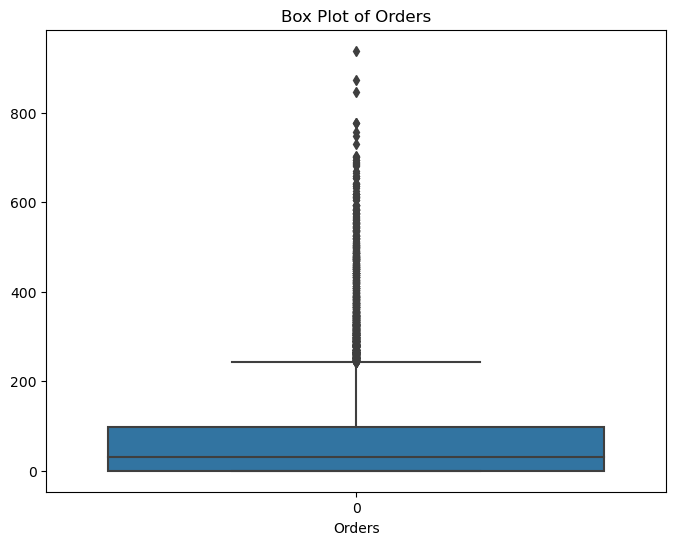

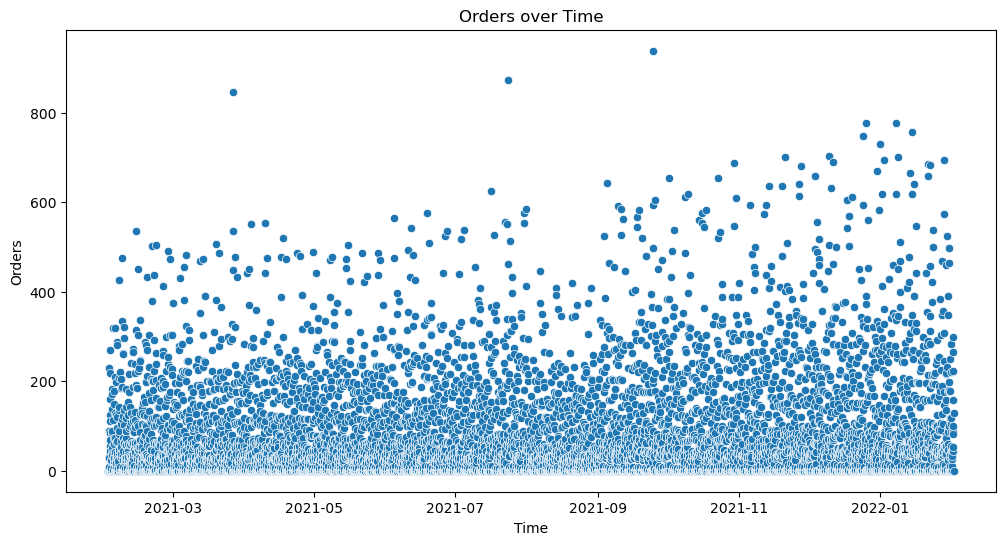

In [83]:
# Box plot of orders to identify outliers
plt.figure(figsize=(8, 6))
sns.boxplot(df['orders'])
plt.title('Box Plot of Orders')
plt.xlabel('Orders')
plt.show()

# Scatter plot of orders against time to identify outliers
plt.figure(figsize=(12, 6))
sns.scatterplot(x='time', y='orders', data=df)
plt.title('Orders over Time')
plt.xlabel('Time')
plt.ylabel('Orders')
plt.show()


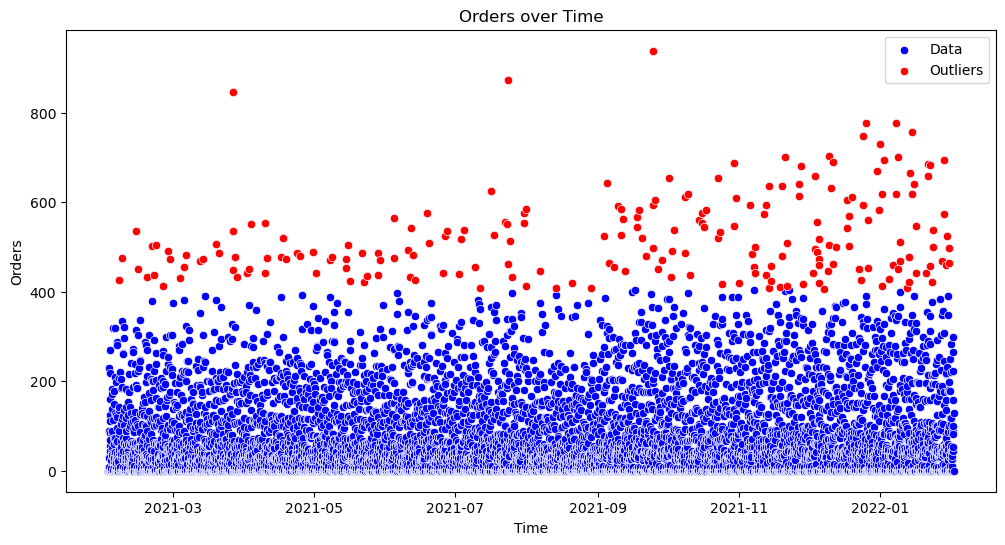

In [84]:
from scipy.stats import zscore

# Calculate the z-scores for the 'orders' column
df['z_scores'] = zscore(df['orders'])

# Identify outliers based on a z-score threshold (e.g., z-score > 3 or < -3)
outliers = df[(df['z_scores'] > 3) | (df['z_scores'] < -3)]

# Scatter plot of orders against time with outliers highlighted
plt.figure(figsize=(12, 6))
sns.scatterplot(x='time', y='orders', data=df, color='blue', label='Data')
sns.scatterplot(x='time', y='orders', data=outliers, color='red', label='Outliers')
plt.title('Orders over Time')
plt.xlabel('Time')
plt.ylabel('Orders')
plt.legend()
plt.show()

## Modelling

Try different models. Validate each model in a way that would imitate the real problem (every sunday you forecast all of next week). Watch out for data leakage. Evaluate each model on MSE and SMAPE. Which one performs better?

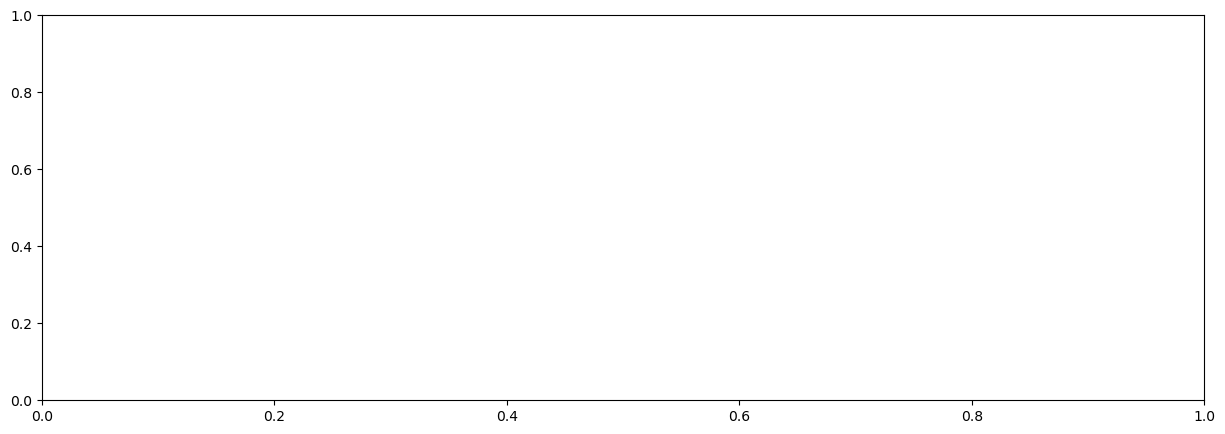

In [85]:
import pandas as pd
from matplotlib import pyplot as plt
import plotly.express as px

fig, ax = plt.subplots(figsize=(15, 5))
px.line(df, x='time', y='orders')

# ARIMA

In [86]:
def smape(y_true, y_pred):
    return 100/len(y_true) * np.sum(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))

In [87]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

# Assuming 'time' column is in datetime format
df['time'] = pd.to_datetime(df['time'])

# Sort the data by the 'time' column in ascending order
df.sort_values('time', inplace=True)

# Split data into training and testing sets
train_df = df.iloc[:-7]  # Train on all data except the last week
test_df = df.iloc[-7:]  # Test on the last week

# Define the ARIMA models to try
arima_orders = [(1, 0, 0), (1, 1, 0), (1, 1, 1), (12, 0, 0)]
results = []

# Iterate over the ARIMA orders
for order in arima_orders:
    # Fit an ARIMA model on the training data
    model = ARIMA(train_df['orders'], order=order)
    model_fit = model.fit()

    # Predict next week's orders using the ARIMA model
    start_date = test_df['time'].min()
    end_date = test_df['time'].max()
    pred = model_fit.predict(start=len(train_df), end=len(train_df)+len(test_df)-1, typ='levels')

    # Evaluate model performance on the testing data
    mse = mean_squared_error(test_df['orders'], pred)
    smape_score = smape(test_df['orders'], pred)

    #c

    # Print the evaluation metrics
    print(f"ARIMA({order[0]},{order[1]},{order[2]})")
    print("MSE:", mse)
    print("SMAPE:", smape_score)
    print()

ARIMA(1,0,0)
MSE: 14511.701566111074
SMAPE: 82.81751105578773

ARIMA(1,1,0)
MSE: 19838.17742520615
SMAPE: 113.12859779343776

ARIMA(1,1,1)
MSE: 20889.18209702815
SMAPE: 125.86517538142697

ARIMA(12,0,0)
MSE: 7738.482082429072
SMAPE: 68.22197953557573



# Rolling Mean

In [88]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error

# Assuming 'time' column is in datetime format
df['time'] = pd.to_datetime(df['time'])

# Sort the data by the 'time' column in ascending order
df.sort_values('time', inplace=True)

# Split data into training and testing sets
train_df = df.iloc[:-7]  # Train on all data except the last week
test_df = df.iloc[-7:]  # Test on the last week

# Calculate rolling mean of the orders
rolling_mean = train_df['orders'].rolling(window=3).mean()

# Repeat the last rolling mean value for the length of the test_df
rolling_mean_last = rolling_mean.iloc[-1]
rolling_mean = rolling_mean.append(pd.Series([rolling_mean_last] * (len(test_df)-2)))

# Evaluate model performance on the testing data
rolling_mean = rolling_mean.tail(len(test_df)).reset_index(drop=True)  # Align lengths
mse = mean_squared_error(test_df['orders'], rolling_mean)
smape_score = smape(test_df['orders'], rolling_mean)

# Create a dictionary to store the results
result = {
    'model_name': 'Rolling_Mean',
    'predictions': rolling_mean,
    'mse': mse,
    'smape': smape_score
}
results.append(result)
# Print the evaluation metrics
print("Rolling Mean")
print("MSE:", mse)
print("SMAPE:", smape_score)

Rolling Mean
MSE: 13406.396825396823
SMAPE: 0.0


/var/folders/hj/n94x31sj08bdmgwjs6ybxbf40000gn/T/ipykernel_32324/135609691.py:20: FutureWarning:

The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



In [89]:
for result in results:
    print(result['model_name'])
    print(result['mse'])
    print(result['smape'])
    print()

ARIMA_100
14511.701566111074
82.81751105578773

ARIMA_110
19838.17742520615
113.12859779343776

ARIMA_111
20889.18209702815
125.86517538142697

ARIMA_1200
7738.482082429072
68.22197953557573

Rolling_Mean
13406.396825396823
0.0



# SARIMAX (to incorporate seasonality to ARIMA)

In [90]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error

# Assuming 'time' column is in datetime format
df['time'] = pd.to_datetime(df['time'])

# Sort the data by the 'time' column in ascending order
df.sort_values('time', inplace=True)

# Split data into training and testing sets
train_df = df.iloc[:-7]  # Train on all data except the last week
test_df = df.iloc[-7:]  # Test on the last week

# Define the SARIMAX models to try
sarimax_orders = [((1, 0, 0), (1, 1, 0, 7)), ((1, 1, 0), (1, 1, 0, 7)), ((1, 1, 1), (1, 1, 0, 7))]

# Iterate over the SARIMAX orders
for order in sarimax_orders:
    # Fit a SARIMAX model on the training data
    model = SARIMAX(train_df['orders'], order=order[0], seasonal_order=order[1])
    model_fit = model.fit()

    # Predict next week's orders using the SARIMAX model
    start_date = test_df['time'].min()
    end_date = test_df['time'].max()
    pred = model_fit.predict(start=len(train_df), end=len(train_df)+len(test_df)-1, typ='levels')

    # Evaluate model performance on the testing data
    mse = mean_squared_error(test_df['orders'], pred)

    # Create a dictionary to store the results
    result = {
        'model_name': f"SARIMAX_{order[0]}_{order[1]}",
        'predictions': pred,
        'mse': mse
    }
    results.append(result)

    # Print the evaluation metrics
    print(f"SARIMAX{order[0]}{order[1]}")
    print("MSE:", mse)
    print()


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.99108D+00    |proj g|=  6.47655D-02

At iterate    5    f=  5.98855D+00    |proj g|=  2.61649D-04

At iterate   10    f=  5.98850D+00    |proj g|=  6.67552D-03

At iterate   15    f=  5.98838D+00    |proj g|=  1.02840D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     16     18      1     0     0   1.602D-06   5.988D+00
  F =   5.9883847436145770     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
SARIMAX(

 This problem is unconstrained.



At iterate    5    f=  6.03285D+00    |proj g|=  8.89055D-04

At iterate   10    f=  6.03271D+00    |proj g|=  1.07119D-02

At iterate   15    f=  6.03258D+00    |proj g|=  5.51168D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     15     17      1     0     0   5.512D-06   6.033D+00
  F =   6.0325752841277369     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
SARIMAX(1, 1, 0)(1, 1, 0, 7)
MSE: 5218.217981487577

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0 

 This problem is unconstrained.



At iterate    5    f=  5.96644D+00    |proj g|=  1.32483D-03

At iterate   10    f=  5.96588D+00    |proj g|=  1.47852D-02

At iterate   15    f=  5.96155D+00    |proj g|=  5.26403D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     19     22      1     0     0   9.900D-07   5.961D+00
  F =   5.9614565596926612     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
SARIMAX(1, 1, 1)(1, 1, 0, 7)
MSE: 6630.708909675903



## LSTM with Rolling Window Approach

My idea was to use a rolling window approach, my thought was, we can fit the model with the past data, then move forward, append the predictions into the training, since we are looking from 'Sunday' on. This will allow us to see any spikes in predictions and consider them as part of the training when predicting the next hour, until we are done with all the prediction orders. We don't see any of the true values, so this avoids data leakage.

In [91]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='loss', patience=2)

df['time'] = pd.to_datetime(df['time'])
df.sort_values('time', inplace=True)

n_hours = 24*7  # Number of past time steps to use for prediction
n_features = 1  # Number of features to use for prediction

def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    if dropnan:
        agg.dropna(inplace=True)
    return agg

model = Sequential()
model.add(LSTM(30, activation='tanh', input_shape=(n_hours, n_features))) 
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(df['orders'].values.reshape(-1, 1))

reframed = series_to_supervised(scaled, n_hours, 1)

values = reframed.values
train = values

n_obs = n_hours * n_features
train_X, train_y = train[:, :n_obs], train[:, -n_features]

train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))

model.fit(train_X, train_y, epochs=5, batch_size =32, verbose=1, callbacks=[early_stop])

predictions = []
for i in range(168):
    input_X = train_X[-1, :].reshape(1, n_hours, n_features)
    yhat = model.predict(input_X)
    predictions.append(yhat[0,0])
    temp = np.append(input_X[0, 1:, :], [[yhat]])
    train_X = np.concatenate((train_X[:-1], temp.reshape(1, n_hours, n_features)))

predictions_lstm = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))
print("Predictions for the upcoming week: ", predictions_lstm)

mse_lstm = mean_squared_error(scaler.inverse_transform(values[:168, -1].reshape(-1,1)), predictions_lstm)
print('Test MSE: %.3f' % mse_lstm)


Epoch 1/5


2023-06-18 17:22:41.789295: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-06-18 17:22:42.094351: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-06-18 17:22:42.813429: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


269/269 [==============================] - 29s 94ms/step - loss: 0.0110
Epoch 2/5
269/269 [==============================] - 23s 86ms/step - loss: 0.0075
Epoch 3/5
269/269 [==============================] - 21s 79ms/step - loss: 0.0046
Epoch 4/5
269/269 [==============================] - 23s 86ms/step - loss: 0.0037
Epoch 5/5
269/269 [==============================] - 23s 86ms/step - loss: 0.0029


2023-06-18 17:24:40.540049: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-06-18 17:24:40.639314: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 62ms/step
Predictions for the upcoming week:  [[ 6.60808086e+00]
 [-1.42709389e+01]
 [-7.26325178e+00]
 [-4.30500889e+00]
 [-6.29563570e+00]
 [-8.67681789e+00]
 [-8.47164822e+00]
 [-4.33877373e+00]
 [ 4.23275232e+00]
 [ 1.74871311e+01]
 [ 3.56594048e+01]
 [ 5.88876724e+01]
 [ 8.66072083e+01]
 [ 1.16080574e+02]
 [ 1.40092392e+02]
 [ 1.46092377e+02]
 [ 1.22669647e+02]
 [ 7.52688675e+01]
 [ 3.71008377e+01]
 [ 5.74741325e+01]
 [ 1.62727707e+02]
 [ 2.87356384e+02]
 [ 2.80446716e+02]
 [ 1.32359665e+02]
 [ 1.90279655e+01]
 [-7.63950157e+00]
 [-5.50310421e+00]
 [-4.24743176e+00]
 [-6.25225306e+00]
 [-8.14857578e+00]
 [-7.39970875e+00]
 [-2.76840305e+00]
 [ 6.25574732e+00]
 [ 1.99484348e+01]
 [ 3.85826187e+01]
 [ 6.23170128e+01]
 [ 9.05452194e+01]
 [ 1.20346901e+02]
 [ 1.44115753e+02]
 [ 1.48904037e+02]
 [ 1.23623734e+02]
 [ 7.53475571e+01]
 [ 3.93645859e+01]
 [ 6.55795135e+01]
 [ 1.76921310e+02]
 [ 2.98617432e+02]
 [ 2.78186676e+02]
 [ 1.23899597e+02]


In [93]:
smape_lstm = smape(scaler.inverse_transform(values[:168, -1].reshape(-1,1)), predictions_lstm)

In [95]:
# Create a dictionary to store the results
result = {
    'model_name': 'LSTM',
    'predictions': predictions_lstm.flatten(),
    'mse': mse_lstm,
    'smape': smape_lstm 
}
results.append(result)

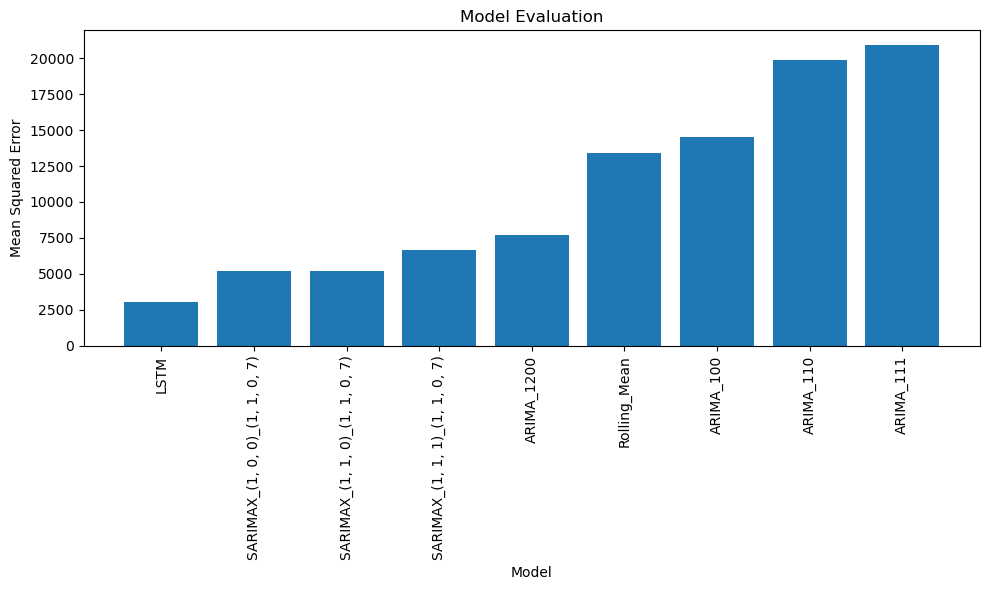

In [96]:
# Sort the results by MSE in ascending order
sorted_results = sorted(results, key=lambda x: x['mse'])

# Extract the model names and MSE values
model_names = [result['model_name'] for result in sorted_results]
mse_values = [result['mse'] for result in sorted_results]

# Plot the MSE values
plt.figure(figsize=(10, 6))
plt.bar(range(len(sorted_results)), mse_values)
plt.xticks(range(len(sorted_results)), model_names, rotation='vertical')
plt.xlabel('Model')
plt.ylabel('Mean Squared Error')
plt.title('Model Evaluation')
plt.tight_layout()
plt.show()
